## 3. Extract Time series from NetCDF files

A quick recap of what we have achieved so far: We batch downloaded the climate data we needed from the DWD Hyras repo. We cropped it to AOI and saw how to extract time series at specific locations. 

Lets have a look:

In [1]:
## First, lets import all neeeded libraries

import os, sys
# import netCDF4
import pandas as pd
#import datetime
#from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import rioxarray
import xarray as xr
#import time
#import gc

In [2]:
pwd = os.getcwd()
print(pwd)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example


In [3]:
bl = "BB" ## enter here the common abbr. for your federal state of choice

## e.g. BB - berlin/ brandenburg, BW  -Baden-Württemberg, SN = Sachsen,....

In [4]:
start_year = 1990 #yyyy
end_year = 2005 #yyy

# Replace 'your_file.nc' with the path to your NetCDF file
file_path = f'data/HYRAS-data_clip/tas_hyras_5__v5-0_de_clip_merged_{start_year}_to_{end_year}.nc'
# Read the NetCDF file into an xarray Dataset
nc_tas = xr.open_dataset(file_path)


# Replace 'your_file.nc' with the path to your NetCDF file
file_path = f'data/HYRAS-data_pr_clip/pr_hyras_1__v5-0_de_clip_merged_{start_year}_to_{end_year}.nc'
# Read the NetCDF file into an xarray Dataset
nc_pr = xr.open_dataset(file_path)

nc_pr

<xarray.Dataset>
Dimensions:             (time: 5844, x: 237, y: 236, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 1990-01-01T18:00:00 ... 2005-12...
  * x                   (x) float32 4.082e+06 4.084e+06 ... 4.318e+06 4.318e+06
  * y                   (y) float32 2.738e+06 2.74e+06 ... 2.972e+06 2.974e+06
    lon                 (y, x) float64 ...
    lat                 (y, x) float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    x_bnds              (x, bnds) float32 ...
    y_bnds              (y, bnds) float32 ...
    crs_HYRAS           int32 ...
    pr                  (time, y, x) float32 ...
    number_of_stations  (time) float64 ...
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 17:58:03
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_1995_day_00638B8E2B
    filename:                  pr_hyras_1_1995_v5-0_de.nc

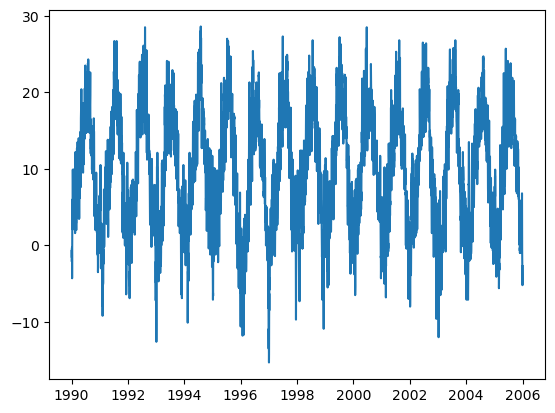

In [5]:
lon = 4.208e+06 # x
lat = 2.842e+06 # y

## two ways of selecting data
## ... 1. by location: .sel
tas = nc_tas.sel(x=lon, y=lat, method="nearest")['tas'].values
time = nc_tas.sel(x=lon, y=lat, method="nearest")['time'].values


plt.plot(time, tas)

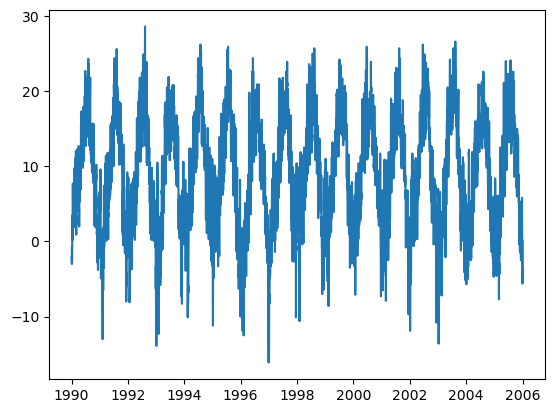

In [6]:
## ... or 2. by index : .isel
plt.plot(nc_tas.isel(x=1, y= 1)['time'].values, 
         nc_tas.isel(x=1, y= 1)['tas'].values)

The above code shows, how to extract data at a specific locations. Our next goal is to extract the data at the specific well locations, to relate groundwater levels and climate data. This is where it gets interesting. We want to extract time series from specific well locations. Unfortunately, Wunsch et al. did not provide us with these coordinates. So how do we proceed?

All we have is the well ID. If we look in the GWData folder we can see that each well has an associated ID in the filename. So here is where you get to work again! **Proceed as follows:**

1. For each federal state theere is a State Office ("Landesamt") where all well data and meta data are managed. Wunsch et al. provided the links to each Landesamt on their [ZENODO repo](https://zenodo.org/records/4683879).

2. E.g. for [Brandenburg state](http://maps.brandenburg.de/WebOffice/?project=GWM_www_WO) click on "Grundwassermesstellen" and enter in the search field each well-ID. I know its tedious work, but some times thats the nature of data preprocessing.

3. Open a new excel file and write a meta data table containing: Well name,Well-ID, x/y-Well coordinates and all the other meta data you can find. Things like elevation, GOK can get really important later on when we try to interpret our results. We want to avoid coming back to that step later on, so just save all information you can find.

4. When you are done, save that excel file to csv. That makes reading it to python much easier!

## 3.1. Find Location of GW wells

Depending on the federal state, the data portals of the federal state offices must be searched for the specific well locations.

> You can find the links to the "Landesämter" [here](https://zenodo.org/records/4683879)!
> 
> For more information on projected coordinate systems and a comprehensive list, [click here](https://pro.arcgis.com/en/pro-app/3.1/help/mapping/properties/pdf/projected_coordinate_systems.pdf).
>
> **Note that x corresponds to lon and y correponds to lat!**
>

I already looked for the locations in [Brandenburg](http://maps.brandenburg.de/WebOffice/?project=GWM_www_WO)! Already mentioned it, quite tedious work...

In [7]:
gw_wells = pd.read_csv(
    f"{bl}_GW_wells.csv",
    sep=";",decimal=",",
    skipinitialspace=True
)
gw_wells

,Gw Messstellen BB,ID,x,y,Beobachtungsbeginn,geländehöhe_m_NN,messpunkthöhe_m_NN,FIOK_m_unter_GOK,FIUK_m_unter_Gok,Comment
0,Lockstädt OP,27381010,301204,5900001,01.05.97,49.70,50.57,13.00,15.00,NaN
1,Beveringen OP,28390113,315001,5892535,01.03.89,69.70,69.70,24.00,28.00,NaN
2,"Schw.,Krzg.Teichm.-Seelenb.str",29519030,451246,5879582,01.12.83,6.00,7.01,NaN,NaN,NaN
3,"Stolpe, Birkenallee",30400591,328394,5872140,01.11.69,43.70,44.36,6.40,7.40,NaN
4,"Wusterhausen, Bahnlinie",31400780,328475,5861312,01.01.30,33.20,34.02,2.90,4.90,NaN
5,Hohenfinow-Struwenberg,31491979,428659,5853630,01.12.97,1.50,2.34,25.86,27.86,laut landesamt: 31491992
6,"Hohenbruch, Weg n.Teerofen",32455305,376839,5851049,01.06.58,37.20,37.43,NaN,NaN,NaN
7,"Bredow, Siedlung Glien",33437070,362459,5831446,01.06.71,31.60,31.94,8.90,10.40,NaN
8,"Perwenitz, Luchstraße, OP",33437090,363274,5832980,01.06.74,32.35,33.16,9.95,11.95,NaN
9,"Nauen, Graf-Arco-Straße",33437106,358447,5833769,01.06.71,31.20,31.75,8.50,10.00,NaN


When trying to intersect raster and vector objects in python, both need to be **georeferenced**! we will convert our pandas well locations into a `geopandas Dataframe`. `geopandas` is the easiest library to handle shapefiles in Python. We already used geopandas in the previous script, where we read our federal state shapefile to geopandas. Remember to set the right crs! Each Landesamt might provide their coordinates in a diffrent EPSG. keep that in mind. Brandenburg delivers theirs in `crs="EPSG:5685"`.

We will pretty much repeat that step, instead of cropping our .nc file to AOI, we will extract point information on a POI (point of interest) level. 

![](https://desktop.arcgis.com/de/arcmap/latest/manage-data/raster-and-images/GUID-50BB42BB-0E81-4D59-85FB-9F75F5D3069B-web.gif) 

*figure from ArcMap 10.8*

In [8]:

## convert into geopandas dataframe
gwl_points = gpd.GeoDataFrame(
    gw_wells, geometry=gpd.points_from_xy(gw_wells.x, gw_wells.y), crs="EPSG:5685"
)
gwl_points

## and set the right crs

gwl_points = gwl_points.to_crs("epsg:3034")

In [9]:
Well_ID = gwl_points.ID
Well_ID

0     27381010
1     28390113
2     29519030
3     30400591
4     31400780
5     31491979
6     32455305
7     33437070
8     33437090
9     33437106
10    33452451
11    33470960
12    34426110
13    34522461
14    37451908
15    39441476
16    39496056
17    42458092
18    40500136
Name: ID, dtype: int64

## 3.2. Extract Temperatrue & precipitation at GW wells


Next, we want to extract timeseries of temp & precip. at each well location. We will merge them into individual .csv files for later processing. Each groundwater well will have a corresponding .csv file containing the climate data. 

In [10]:
## set current WD
os.chdir(pwd)

## specify wd
path = "data/"
new_dir = os.path.join(path, "HYRAS_CSV")
if not os.path.exists(new_dir):
    os.makedirs(new_dir)



new_dir

'data/HYRAS_CSV'

##### Set naming convention (following Wunsch et al.'s code)

In [25]:
## naming convention
file_end_name = "_weeklyData_HYRAS"
file_ext_name = ".csv"
well_id = gwl_points.ID[0]

file_name = f"{bl}_{well_id}{file_end_name}{file_ext_name}"
file_name

'BB_27381010_weeklyData_HYRAS.csv'

In [26]:
filepath = f"{new_dir}/{well_id}{file_end_name}{file_ext_name}"
filepath

'data/HYRAS_GWData_csv/27381010_weeklyData_HYRAS.csv'

In [13]:
## initialise empty df only with time columns

time = nc_tas.sel(x=lon, y=lat, method="nearest")['time'].values


## concat new columns to df and give column name

for i in range(0,gwl_points.shape[0]):
    tas = nc_tas.sel(x=gwl_points.x[i], y=gwl_points.y[i], method="nearest")['tas'].values
    tas_interim = pd.DataFrame({'Date': time, 'tas': tas})

    pr = nc_pr.sel(x=gwl_points.x[i], y=gwl_points.y[i], method="nearest")['pr'].values
    pr_interim = pd.DataFrame({'Date': time, 'pr': pr})

    pr_interim.set_index('Date', inplace=True)
    tas_interim.set_index('Date', inplace=True)    
    
    well_id = gwl_points.ID[i]
    
   # filepath = f"{new_dir}/{well_id}{file_end_name}{file_ext_name}"

  #  data = pd.merge(tas_interim, pr_interim, left_index=True, right_index=True)#on="Date")
   # data.to_csv(filepath) 
    print(f"{well_id}.....Loaded successfully")
   

27381010.....Loaded successfully
28390113.....Loaded successfully
29519030.....Loaded successfully
30400591.....Loaded successfully
31400780.....Loaded successfully
31491979.....Loaded successfully
32455305.....Loaded successfully
33437070.....Loaded successfully
33437090.....Loaded successfully
33437106.....Loaded successfully
33452451.....Loaded successfully
33470960.....Loaded successfully
34426110.....Loaded successfully
34522461.....Loaded successfully
37451908.....Loaded successfully
39441476.....Loaded successfully
39496056.....Loaded successfully
42458092.....Loaded successfully
40500136.....Loaded successfully


Ok, perfect! We finally preprocessed our climate data in to .csv files that we can feed in to ML approaches. What a process!

We still got one more thing to do: merge the climate data and the gw well data into csv files.

**Wait a minute!** We are facing one more problem! Have you noticed the difference in the GWData timeseries and our freshly preprocessed time series? Let's have a look. As an example we will look into our first well in the dataset. 

In [14]:
nc_tas.attrs["frequency"]

'day'

In [15]:
Well_ID = gwl_points.ID[0]
pathGW = "data/GWData/"
GWData = pd.read_csv(f"{pathGW}BB_{Well_ID}_GW-Data.csv", 
                          parse_dates=['Date'],index_col=0, dayfirst = True, 
                          decimal = '.', sep=',')

GWData

,GWL
Date,
1997-04-14,48.520
1997-04-21,48.535
1997-04-28,48.550
1997-05-05,48.590
1997-05-12,48.550
...,...
2018-03-19,48.950
2018-03-26,48.930
2018-04-02,48.980


Remember the first script in this tutorial? We checked the time resolution of our .nc files. We can clearly see that we are dealing with **daily** data for the HYRAS climate data!

But when we look at the well data (GWData) we see that they are on **weekly** time intervals!

What a bummer, merging them won't be straightforward unfortunately...

And we even have different length, start and end dates for our well location time series. Let us solve this problem first:

In [16]:
from datetime import datetime

#### 1. Downsample our climate data to weekly intervals and then merge: 

**Customizing the Aggregation**

You might want to aggregate the daily data differently depending on your requirements:

> `Sum`: If you want the total value over the week.
>
> `Mean`: If you want the average value over the week.
>
> `Max`: If you want the maximum value within the week.

In [17]:
pr_interim = pr_interim.resample('7D').sum() ## origin=datetime(1997,4,14) set this if you want within resamle
tas_interim = tas_interim.resample('7D').mean()

In [18]:
pr_tas_interim = pd.merge_asof(pr_interim, tas_interim, on='Date', direction='nearest')


#### A note on `pd.merge_asof`:

The pd.merge_asof function in pandas has three options for the direction parameter. These options determine how the function handles merging when the exact key is not found. The options are:

> `backward`:
>
>This option matches each row in the left DataFrame to the nearest key in the right DataFrame that is less than or equal to the left key.
Example: If the left key is 2023-01-04 and the nearest right keys are 2023-01-01 and 2023-01-08, it will match with 2023-01-01.
>
> `forward`:
>
>This option matches each row in the left DataFrame to the nearest key in the right DataFrame that is greater than or equal to the left key.
Example: If the left key is 2023-01-04 and the nearest right keys are 2023-01-01 and 2023-01-08, it will match with 2023-01-08.
>
> `nearest`:
>
>This option matches each row in the left DataFrame to the nearest key in the right DataFrame, whether it is less than or greater than the left key.
Example: If the left key is 2023-01-04 and the nearest right keys are 2023-01-01 and 2023-01-08, it will match with the closest one, which depends on the absolute



#### 2. Merge well and climate data :

In [19]:
pd.merge_asof(pr_tas_interim, GWData, on='Date', direction='backward')


,Date,pr,tas,GWL
0,1990-01-01,1.0,-0.728571,NaN
1,1990-01-08,3.3,3.871429,NaN
2,1990-01-15,12.6,6.185714,NaN
3,1990-01-22,26.4,5.742857,NaN
4,1990-01-29,4.9,6.057143,NaN
...,...,...,...,...
830,2005-11-28,6.0,0.357143,48.29
831,2005-12-05,3.1,2.942857,48.29
832,2005-12-12,30.5,3.200000,48.28
833,2005-12-19,14.7,3.485714,48.27


### 3.3. Merge climate data into one csv each

In [20]:
## initialise empty df only with time columns

time = nc_tas.sel(x=lon, y=lat, method="nearest")['time'].values


## concat new columns to df and give column name

for i in range(0,gwl_points.shape[0]):
    ## extract well id and set file path to save file at
    well_id = gwl_points.ID[i]
    filepath = f"{new_dir}/{bl}_{well_id}{file_end_name}{file_ext_name}"
    
    ## load climate data and reset index to datetime
    tas = nc_tas.sel(x=gwl_points.x[i], y=gwl_points.y[i], method="nearest")['tas'].values
    tas_interim = pd.DataFrame({'Date': time, 'tas': tas})
    tas_interim.set_index('Date', inplace=True)    

    pr = nc_pr.sel(x=gwl_points.x[i], y=gwl_points.y[i], method="nearest")['pr'].values
    pr_interim = pd.DataFrame({'Date': time, 'pr': pr})
    pr_interim.set_index('Date', inplace=True)

    ## resample time series to weekly interval
    pr_interim = pr_interim.resample('7D').sum() ## origin=datetime(1997,4,14) set this if you want within resamle
    tas_interim = tas_interim.resample('7D').mean()
    
    ## merge into one df: 

    pr_tas_interim = pd.merge_asof(pr_interim, tas_interim, on='Date', direction='nearest')

 
    pr_tas_interim.to_csv(filepath) 
    print(f"{filepath}.....Saved successfully")
   

data/HYRAS_CSV/BB_27381010_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_28390113_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_29519030_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_30400591_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_31400780_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_31491979_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_32455305_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_33437070_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_33437090_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_33437106_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_33452451_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_33470960_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_34426110_weeklyData_HYRAS.csv.....Saved successfully
data/HYRAS_CSV/BB_34522461_weeklyData_HYRAS.csv.....Saved successfully
data/H

### 3.4. Merge climate and well data into one csv each

In [21]:
## set current WD
os.chdir(pwd)

## specify wd
path = "data/"
new_dir = os.path.join(path, "HYRAS_GWData_csv")
if not os.path.exists(new_dir):
    os.makedirs(new_dir)



new_dir

'data/HYRAS_GWData_csv'

In [22]:
#define where to find the data
pathGW = "./data/GWData/"
pathHYRAS = "./data/HYRAS_CSV/"
pathconnect = "/"
    
#load a list of all sites
Well_ID = gwl_points.ID


## set naming convention

## naming convention
file_end_name = "_weeklyData_HYRAS_GWData"
file_ext_name = ".csv"

In [23]:
for i in range(0,gwl_points.shape[0]):
    ## extract well id and set file path to save file at
    well_id = gwl_points.ID[i]
    filepath = f"{new_dir}/{well_id}{file_end_name}{file_ext_name}"

    
    GWData = pd.read_csv(f"{pathGW}{bl}_{well_id}_GW-Data.csv", 
                          parse_dates=['Date'],index_col=0, dayfirst = True, 
                          decimal = '.', sep=',')#.set_index('Date', inplace=True) 

    HYRASData = pd.read_csv(f"{pathHYRAS}{bl}_{well_id}_weeklyData_HYRAS.csv",
                            parse_dates=['Date'],index_col=0, dayfirst = True,
                            decimal = '.', sep=',')
    HYRASData['Date'] = pd.to_datetime(HYRASData['Date'])
    HYRASData.set_index('Date', inplace=True) 

    data = pd.merge_asof(HYRASData, GWData, on='Date', direction='backward')


    filepath = f"{new_dir}/{bl}_{well_id}{file_end_name}{file_ext_name}"
    
    data.to_csv(filepath) 
    print(f"{filepath}.....Saved successfully")



data/HYRAS_GWData_csv/BB_27381010_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_28390113_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_29519030_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_30400591_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_31400780_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_31491979_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_32455305_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_33437070_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_33437090_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_33437106_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_33452451_weeklyData_HYRAS_GWData.csv.....Saved successfully
data/HYRAS_GWData_csv/BB_33470960_weeklyData_HYRAS_GWData.csv....

In [24]:
data

,Date,pr,tas,GWL
0,1990-01-01,1.0,-0.728571,52.140
1,1990-01-08,3.3,3.871429,52.150
2,1990-01-15,12.6,6.185714,52.160
3,1990-01-22,26.4,5.742858,52.180
4,1990-01-29,4.9,6.057143,52.180
...,...,...,...,...
830,2005-11-28,6.0,0.357143,51.960
831,2005-12-05,3.1,2.942857,51.980
832,2005-12-12,30.5,3.200000,51.930
833,2005-12-19,14.7,3.485714,51.990


##### I promise we are now done with the data pre-processing! Our data is now ready to be fed into ML algorithms. We will deal with this in the next script. 